In [67]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [68]:
df = pd.read_csv("meteo_data.csv")
df

,SOLAR_RADIATION,PRECIPITATION,WIND_SPEED,LEAF_WETNESS,HC_AIR_TEMPERATURE,HC_RELATIVE_HUMIDITY,DEW_POINT,Date
0,0.0,0.0,0.1,0.0,15.81,100.00,15.7,2022-09-21 20:00:00
1,0.0,0.0,0.0,0.0,15.81,100.00,15.7,2022-09-21 21:00:00
2,0.0,0.0,0.2,0.0,15.83,88.69,0.0,2022-09-21 22:00:00
3,0.0,0.0,0.3,0.0,15.97,73.08,11.0,2022-09-21 23:00:00
4,0.0,0.0,1.1,0.0,15.55,61.41,8.0,2022-09-22 00:00:00
...,...,...,...,...,...,...,...,...
13709,539.0,0.0,5.5,0.0,19.05,91.66,0.0,2024-04-15 15:00:00
13710,428.0,0.0,5.7,0.0,19.23,0.00,0.0,2024-04-15 16:00:00
13711,277.0,0.0,5.0,0.0,18.33,0.00,0.0,2024-04-15 17:00:00
13712,135.0,0.0,4.9,0.0,17.47,25.00,0.0,2024-04-15 18:00:00


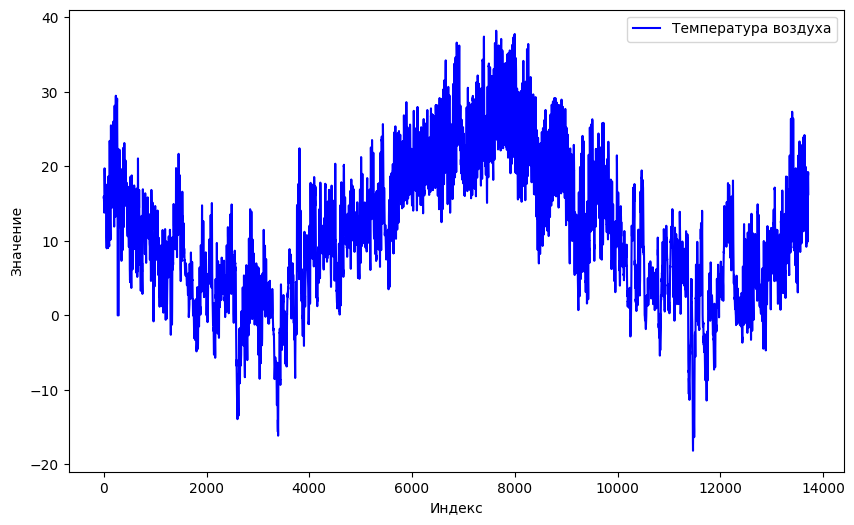

In [69]:
temp = df['HC_AIR_TEMPERATURE']
# Создание массива индексов для оси X
indices = np.arange(len(temp))

plt.figure(figsize=(10, 6))
plt.plot(indices, temp, label='Температура воздуха', color='blue')

# Настройка графика
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()

# Показать график
plt.show()

In [70]:
temp

0        15.81
1        15.81
2        15.83
3        15.97
4        15.55
         ...  
13709    19.05
13710    19.23
13711    18.33
13712    17.47
13713    16.26
Name: HC_AIR_TEMPERATURE, Length: 13714, dtype: float64

In [71]:
avg_temp = []
count = 0
sum_temp = 0
for i in range(len(temp)):
    if count == 24:
        avg_temp.append(sum_temp / 24)
        sum_temp = 0
        count = 0
    else:
        sum_temp += temp[i]
        count += 1

# Добавить последнее среднее значение, если оно не было добавлено
if count != 0:
    avg_temp.append(sum_temp / count)

temp = avg_temp
print(len(avg_temp))

549


In [78]:
import pandas as pd

# Преобразовать avg_temp в объект DataFrame
avg_temp_df = pd.DataFrame(avg_temp, columns=['HC_AIR_TEMPERATURE'])
#avg_temp_df = avg_temp_df.drop(avg_temp_df.columns[0], axis=1)
avg_temp_df.reset_index(drop=True, inplace=True)
print(avg_temp_df)

     HC_AIR_TEMPERATURE
0             16.117500
1             15.233750
2             12.210833
3             13.402083
4             15.622917
..                  ...
544           17.426667
545           17.362083
546           14.998333
547           14.282917
548           16.688571

[549 rows x 1 columns]


In [79]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [80]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(avg_temp_df, WINDOW_SIZE)
X1.shape, y1.shape

((544, 5, 1, 1), (544, 1))

In [65]:
X_train1, y_train1 = X1[:10000], y1[:10000]
X_val1, y_val1 = X1[10000:11500], y1[10000:11500]
X_test1, y_test1 = X1[11500:], y1[11500:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((544, 5, 1, 1), (544, 1), (0, 5, 1, 1), (0, 1), (0, 5, 1, 1), (0, 1))

In [134]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 4, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 8)                   │           2,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257 (8.82 KB)

 Trainable params: 2,257 (8.82 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
cp2 = ModelCheckpoint('model2/model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [136]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 269.0513 - root_mean_squared_error: 16.2750 - val_loss: 4.3219 - val_root_mean_squared_error: 2.0802
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2985 - root_mean_squared_error: 2.6978 - val_loss: 2.3830 - val_root_mean_squared_error: 1.5440
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4579 - root_mean_squared_error: 2.1095 - val_loss: 1.7738 - val_root_mean_squared_error: 1.3319
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.0189 - root_mean_squared_error: 1.7362 - val_loss: 1.3246 - val_root_mean_squared_error: 1.1507
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1063 - root_mean_squared_error: 1.4509 - val_loss: 1.1199 - val_root_mean_squared_error: 1.0580
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7386 - root_mean_squared_error: 1.3182 - val_loss: 1.0062 - val_root_mean_squared_error: 1.0028
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


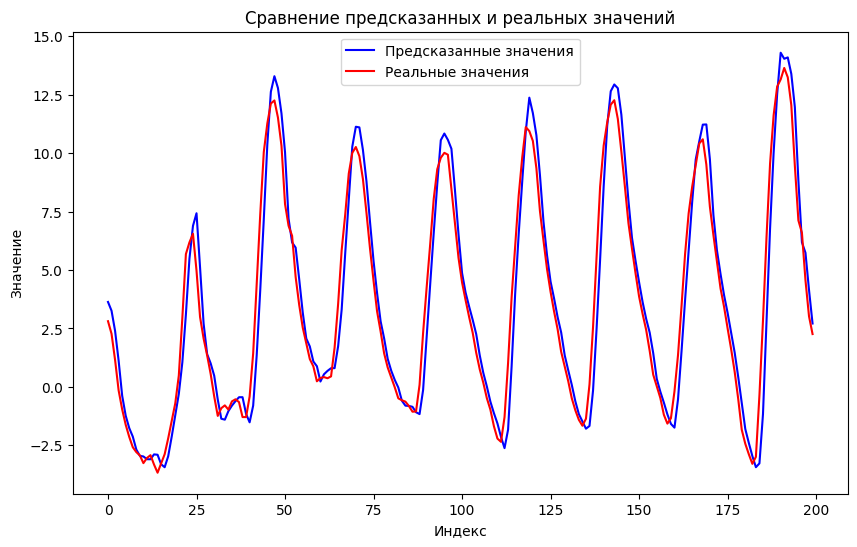

In [137]:
# Предсказание на тестовом наборе данных
y_pred1 = model2.predict(X_test1)

# Построение графика предсказанных и реальных значений
plt.figure(figsize=(10, 6))
plt.plot(y_pred1[1300:1500], label='Предсказанные значения', color='blue')
plt.plot(y_test1[1300:1500], label='Реальные значения', color='red')
plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [138]:
# Оценка MAE
mae = mean_absolute_error(y_test1, y_pred1)

# Оценка MSE
mse = mean_squared_error(y_test1, y_pred1)

# Оценка RMSE
rmse = np.sqrt(mse)

# Оценка R^2
r2 = r2_score(y_test1, y_pred1)

print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя квадратичная ошибка (MSE):", mse)
print("Корень из среднеквадратичной ошибки (RMSE):", rmse)
print("Коэффициент детерминации (R^2):", r2)

Средняя абсолютная ошибка (MAE): 0.6838475833393732
Средняя квадратичная ошибка (MSE): 0.8461553988326701
Корень из среднеквадратичной ошибки (RMSE): 0.9198670549773321
Коэффициент детерминации (R^2): 0.9773941588977151
